# DistilBERT for Text Classification
 - ref: Transformer를 활용한 자연어처리

In [ ]:
# Base requirements
!pip install transformers[tf,torch,sentencepiece,vision,optuna,sklearn,onnxruntime]==4.11.3
!pip install  datasets[audio]==1.16.1
!pip install  matplotlib
!pip install ipywidgets
# Chapter 2 - Classification
!pip install umap-learn==0.5.1
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 21.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.

In [ ]:
import torch

# 텍스트 분류

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_tweet.png?raw=1" id="tesla-tweet"/>

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_hf-libraries.png?raw=1" id="hf-libraries"/>

## 데이터셋

### 허깅 페이스 데이터셋 처음 사용하기

In [ ]:
from huggingface_hub import list_datasets

all_datasets = [ds.id for ds in list_datasets()]
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

현재 허브에는 80454개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


각 데이터셋은 고유한 이름이 있습니다. `load_dataset()` 함수로 `emotion` 데이터셋을 로드해보죠.

In [ ]:
from datasets import load_dataset

# emotion 데이터셋이 다운로드되지 않으면 SetFit/emotion을 사용합니다.
emotions = load_dataset("SetFit/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/279k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/276k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/SetFit___emotion-89147fdf376d67e2/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [ ]:
# SetFit/emotion 데이터셋의 경우 수동으로 ClassLabel 객체를 만들어 label에 할당합니다.
from datasets import ClassLabel

emotions['train'].features['label'] = ClassLabel(
    num_classes=6,
    names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [ ]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [ ]:
train_ds.column_names

['text', 'label', 'label_text']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None), 'label_text': Value(dtype='string', id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3], 'label_text': ['sadness', 'sadness', 'anger', 'love', 'anger']}


In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [ ]:
#데이터가 저장소에 없을경우 우리 데이터로 직접 로드 하는것도 가능
#emotions_local = load_dataset("csv", data_files="train.txt", sep=";",names=["text", "label"])

### 데이터셋에서 데이터프레임으로

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
emotions["train"].features['label'].__class__

datasets.features.features.ClassLabel

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_text,label_name
0,i didnt feel humiliated,0,sadness,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger,anger
3,i am ever feeling nostalgic about the fireplac...,2,love,love
4,i am feeling grouchy,3,anger,anger


### 클래스 분포 살펴 보기

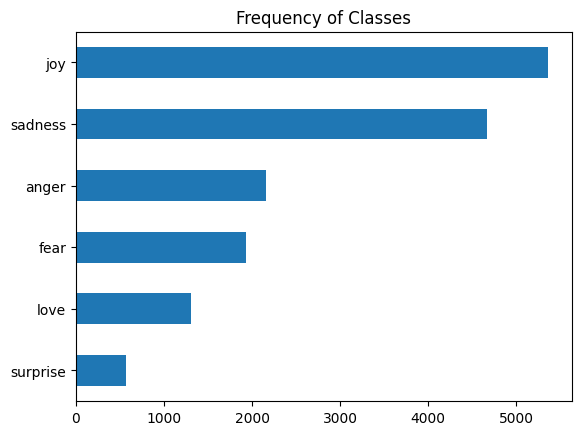

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### 트윗 길이 확인

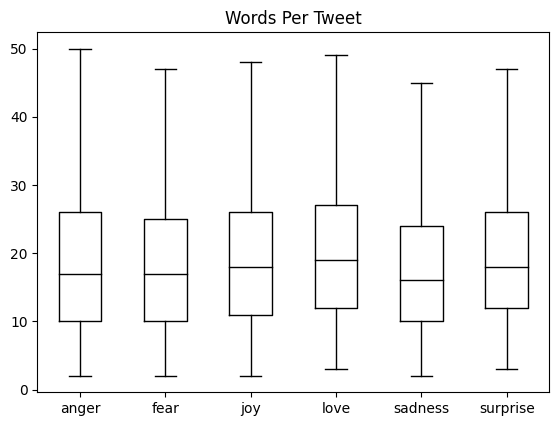

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
emotions.reset_format()

## 텍스트에서 토큰으로

### 부분단어 토큰화

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
text = "I want go home"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2215, 2175, 2188, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'want', 'go', 'home', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i want go home [SEP]


In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 전체 데이터셋 토큰화하기

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/>

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(emotions_encoded["train"].column_names)

['attention_mask', 'input_ids', 'label', 'label_text', 'text']


## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

In [ ]:

from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

#### 마지막 은닉 상태 추출하기

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [ ]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
emotions_hidden["train"].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'label_text', 'text']

In [ ]:
emotions_hidden["train"][0]["hidden_state"]

#### 특성 행렬 만들기

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### 훈련 세트 시각화하기

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.10/dist-packages/umap/distances.py:1053: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1061: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1076: NumbaDeprecationWarning: The 'nopython' keyword argume

,X,Y,label
0,3.813730,6.722785,0
1,-3.378296,5.983040,0
2,5.035090,3.343527,3
3,-2.677467,3.916733,2
4,-3.766084,3.807059,3


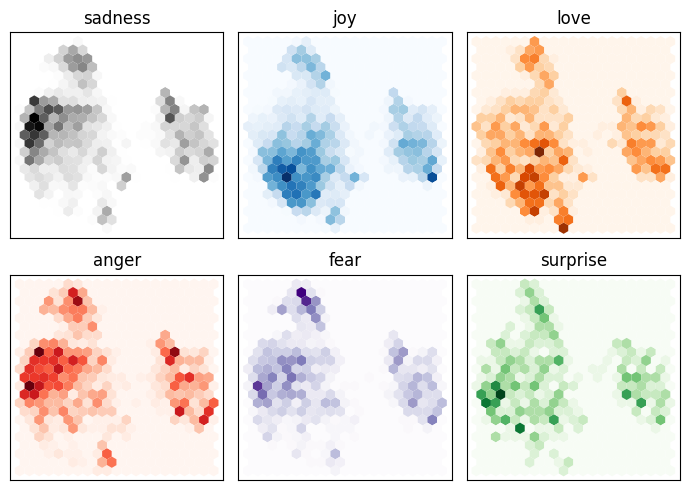

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [ ]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

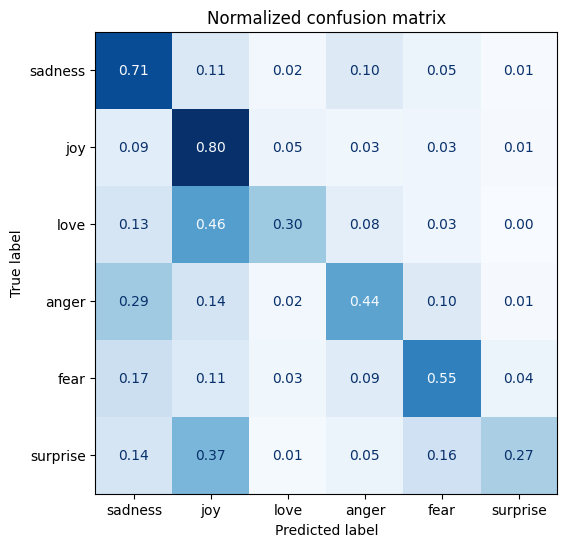

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 트랜스포머 미세 튜닝하기

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 성공 지표 정의하기

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

ImportError: ignored

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### 오류 분석

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

#### 모델 저장 및 공유

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
from transformers import pipeline

# `kyungtae`를 자신의 허브 사용자 이름으로 바꾸세요.
model_id = "kyungtae/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, top_k=None)

In [ ]:
preds_sorted = sorted(preds, key=lambda d: d['label'])
preds_df = pd.DataFrame(preds_sorted)
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## 결론